**Download the dataset file and unzip it.**

In [1]:
!wget https://github.com/shenasa-ai/iranian-car-license-plate/raw/main/iclp-part1.zip
!unzip -qq iclp-part1.zip

--2024-06-24 17:58:33--  https://github.com/shenasa-ai/iranian-car-license-plate/raw/main/iclp-part1.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shenasa-ai/iranian-car-license-plate/main/iclp-part1.zip [following]
--2024-06-24 17:58:33--  https://raw.githubusercontent.com/shenasa-ai/iranian-car-license-plate/main/iclp-part1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21385713 (20M) [application/zip]
Saving to: ‘iclp-part1.zip’

iclp-part1.zip      100%[===================>]  20.39M  72.3MB/s    in 0.3s    

2024-06-24 17:58:33 (72.3 MB/s) - ‘iclp-part1.zip’ saved [21385713/21

**Importing necessary library.**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
data_path = Path("./iclp-part1/")

In [4]:
# Retrieve and sort the list of image files
image_files = sorted([str(file) for file in data_path.glob("*.jpg")])
# Extract labels from image filenames
labels_list = [file.split(os.path.sep)[-1].split(".png")[0].split("_")[0] for file in image_files]

**Display the number of images and labels**

In [5]:
print(f"Total images: {len(image_files)}")
print(f"Total labels: {len(labels_list)}")

Total images: 3000
Total labels: 3000


**Identify unique characters in the labels**

In [6]:
unique_characters = sorted(set(char for label in labels_list for char in label))
print(f"Unique characters: {len(unique_characters)}")
print(f"Characters: {unique_characters}")

Unique characters: 26
Characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'H', 'J', 'K', 'L', 'M', 'N', 'S', 'T', 'V', 'X', 'Y', 'Z']


In [8]:
batch_sz = 16
image_width = 256
image_height = 65
downscale_factor = 4
max_label_length = max(len(label) for label in labels_list)

**Create mappings for characters to numbers and vice versa**

In [9]:
char_to_num = layers.StringLookup(vocabulary=list(unique_characters), mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

**Function to split data into training and validation sets**

In [10]:
def split_dataset(images, labels, train_ratio=0.9, shuffle=True):
    data_size = len(images)
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    train_size = int(data_size * train_ratio)
    train_images, val_images = images[indices[:train_size]], images[indices[train_size:]]
    train_labels, val_labels = labels[indices[:train_size]], labels[indices[train_size:]]
    return train_images, val_images, train_labels, val_labels

In [11]:
train_images, val_images, train_labels, val_labels = split_dataset(np.array(image_files), np.array(labels_list))

**Function to preprocess images and encode labels**

In [12]:
def preprocess_and_encode(image_path, label):
    # Load image
    image = tf.io.read_file(image_path)
    # Decode image and convert to grayscale
    image = tf.io.decode_png(image, channels=1)
    # Normalize and resize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [image_height, image_width])
    # Transpose the image for correct input shape
    image = tf.transpose(image, perm=[1, 0, 2])
    # Convert label to numeric format
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": image, "label": label}

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(preprocess_and_encode, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_sz).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.map(preprocess_and_encode, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_sz).prefetch(buffer_size=tf.data.AUTOTUNE)

**Visualize some samples**

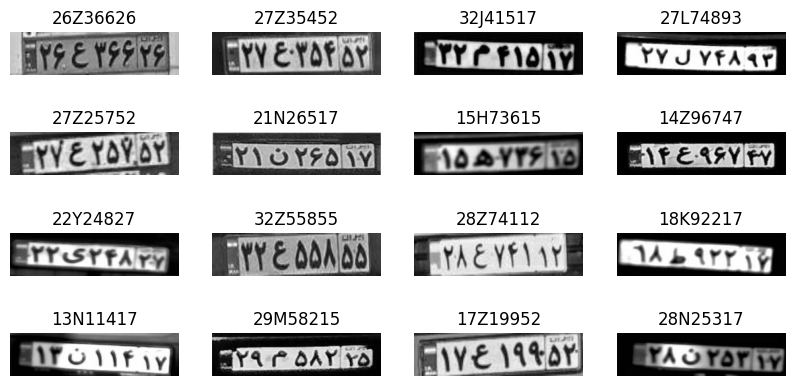

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_ds.take(1):
    imgs = batch["image"]
    lbls = batch["label"]
    for i in range(16):
        img = (imgs[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(lbls[i])).numpy().decode("utf-8")
        axes[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        axes[i // 4, i % 4].set_title(label)
        axes[i // 4, i % 4].axis("off")
plt.show()

**Define CTC layer for the model**

In [15]:
class CTC_LossLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_function = keras.backend.ctc_batch_cost

    def call(self, true_labels, predicted_logits):
        batch_size = tf.cast(tf.shape(true_labels)[0], dtype="int64")
        input_len = tf.cast(tf.shape(predicted_logits)[1], dtype="int64")
        label_len = tf.cast(tf.shape(true_labels)[1], dtype="int64")

        input_len = input_len * tf.ones(shape=(batch_size, 1), dtype="int64")
        label_len = label_len * tf.ones(shape=(batch_size, 1), dtype="int64")

        loss = self.loss_function(true_labels, predicted_logits, input_len, label_len)
        self.add_loss(loss)
        return predicted_logits

**Build the OCR model**

In [16]:
def create_ocr_model():
    input_img = layers.Input(shape=(image_width, image_height, 1), name="image", dtype="float32")
    labels_input = layers.Input(name="label", shape=(None,), dtype="float32")

    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_img)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Reshape and dense layer
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    # RNN layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax")(x)

    # Add CTC loss layer
    output = CTC_LossLayer(name="ctc_loss")(labels_input, x)

    # Define and compile the model
    model = keras.models.Model(inputs=[input_img, labels_input], outputs=output)
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer)
    return model

**Instantiate and summarize the model**

In [17]:
ocr_model = create_ocr_model()
ocr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 256, 65, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 65, 32)          320       ['image[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 32, 32)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 32, 64)          18496     ['max_pooling2d[0][0]']   

In [19]:
num_epochs = 100
patience = 10

# Early stopping callback
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=patience, restore_best_weights=True
)

# Train the model
training_history = ocr_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    callbacks=[early_stopping_callback],
)

Epoch 1/100
169/169 [==============================] - 28s 71ms/step - loss: 24.8310 - val_loss: 21.1549
Epoch 2/100
169/169 [==============================] - 6s 37ms/step - loss: 20.5479 - val_loss: 19.9836
Epoch 3/100
169/169 [==============================] - 7s 43ms/step - loss: 19.5310 - val_loss: 19.2309
Epoch 4/100
169/169 [==============================] - 7s 39ms/step - loss: 18.9062 - val_loss: 18.8232
Epoch 5/100
169/169 [==============================] - 6s 34ms/step - loss: 18.3365 - val_loss: 18.3533
Epoch 6/100
169/169 [==============================] - 6s 36ms/step - loss: 17.8761 - val_loss: 18.1164
Epoch 7/100
169/169 [==============================] - 6s 33ms/step - loss: 17.6804 - val_loss: 18.0068
Epoch 8/100
169/169 [==============================] - 6s 33ms/step - loss: 17.5814 - val_loss: 17.9383
Epoch 9/100
169/169 [==============================] - 6s 33ms/step - loss: 17.4804 - val_loss: 17.8738
Epoch 10/100
169/169 [==============================] - 8s 45ms

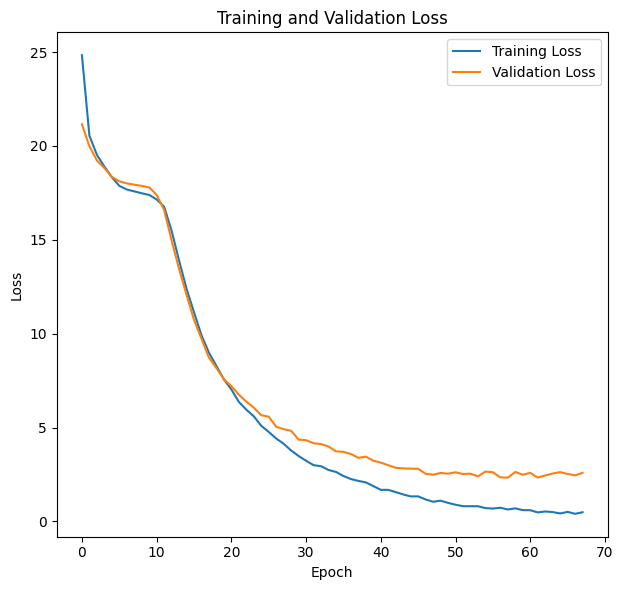

Final Training Loss: 0.4889066517353058
Final Validation Loss: 2.5881121158599854


In [27]:
import matplotlib.pyplot as plt

# Plotting function
def plot_training_history(history):
    # Plotting loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Check if accuracy is available
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(training_history)

# Display important information
print("Final Training Loss:", training_history.history['loss'][-1])
print("Final Validation Loss:", training_history.history['val_loss'][-1])

**Evaluate the model**

In [20]:
validation_loss = ocr_model.evaluate(val_ds)
print(f"Validation loss: {validation_loss}")

19/19 [==============================] - 1s 35ms/step - loss: 2.3330
Validation loss: 2.333000659942627


**Prediction model for inference**

In [21]:
inference_model = keras.models.Model(
    ocr_model.get_layer(name="image").input,
    ocr_model.get_layer(name="dense_1").output
)
inference_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 65, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 256, 65, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 32, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 32, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 16, 64)        0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 64, 1024)          0   

**Function to decode predictions**

In [22]:
def decode_predictions(preds):
    input_length = np.ones(preds.shape[0]) * preds.shape[1]
    results = keras.backend.ctc_decode(preds, input_length=input_length, greedy=True)[0][0][:, :max_label_length]
    decoded_texts = [tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8") for result in results]
    return decoded_texts

**Visualize predictions**

1/1 [==============================] - 1s 1s/step


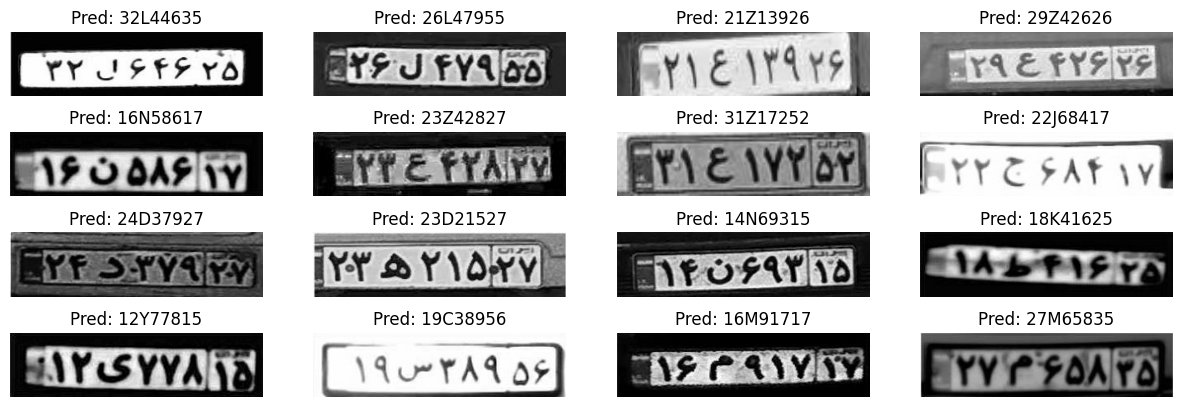

In [23]:
for batch in val_ds.take(1):
    imgs = batch["image"]
    lbls = batch["label"]
    preds = inference_model.predict(imgs)
    pred_texts = decode_predictions(preds)

    original_texts = [tf.strings.reduce_join(num_to_char(lbl)).numpy().decode("utf-8") for lbl in lbls]

    fig, axes = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (imgs[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Pred: {pred_texts[i]}"
        axes[i // 4, i % 4].imshow(img, cmap="gray")
        axes[i // 4, i % 4].set_title(title)
        axes[i // 4, i % 4].axis("off")
plt.show()